In [ ]:
from functools import reduce
from operator import and_
from datetime import datetime

import pandas as pd
import folium
import seaborn as sns

sns.set(rc={'figure.figsize':(11.7,8.27)})
folium_colors = ("black", "blue", "darkgreen", "darkpurple", "darkred", "orange", "pink", "purple", "red", "darkgreen")

def data_selection(df: pd.DataFrame, filters_: dict):
    filters = [df[column].apply(func) for column, func in filters_.items()]
    return df[reduce(and_, filters)].copy().reset_index(drop = True)

columns = ["Date", "Primary Type", "Location Description", "Arrest", "Latitude", "Longitude"]

df_full = pd.read_csv("data/Chicago_Crimes_2012_to_2017.csv", header = 0)
df_full.dropna(subset = columns, inplace = True)

df = df_full.sample(20_000)
df["parsed_date"] = pd.to_datetime(df["Date"])
df["weekofyear"] = df.parsed_date.dt.isocalendar().week
df["monthofyear"] = df.parsed_date.dt.month

In [ ]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

df.head()

Unnamed: 0        ID Case Number                    Date  \
430437      2765096   8989105    HW136367  01/29/2013 03:33:00 PM   
175992      2509514   8585851    HV260049  04/25/2012 09:00:00 PM   
130515      2463455   8511166    HV188225  03/08/2012 09:38:00 AM   
701417      3036667   9428093    HW572289  12/14/2013 05:05:00 PM   
1213225     4028310  10401729    HZ138397  02/02/2016 10:15:00 PM   

                       Block  IUCR     Primary Type              Description  \
430437       002XX W 37TH ST  2024        NARCOTICS      POSS: HEROIN(WHITE)   
175992   040XX S DEARBORN ST  1310  CRIMINAL DAMAGE              TO PROPERTY   
130515      035XX E 114TH ST  0460          BATTERY                   SIMPLE   
701417    055XX N HARLEM AVE  0820            THEFT           $500 AND UNDER   
1213225  075XX S CHAPPEL AVE  0486          BATTERY  DOMESTIC BATTERY SIMPLE   

                  Location Description  Arrest  Domestic  Beat  District  \
430437                   CHA APARTMENT    True     False   915       9.0   
175992                       APARTMENT   False     False   213       2.0   
130515        SCHOOL, PUBLIC, BUILDING   False     False   433       4.0   
701417                    CTA BUS STOP   False     False  1612      16.0   
1213225  RESIDENTIAL YARD (FRONT/BACK)   False      True   414       4.0   

         Ward  Community Area FBI Code  X Coordinate  Y Coordinate  Year  \
430437    3.0            34.0       18     1175378.0     1880434.0  2013   
175992    3.0            38.0       14     1176638.0     1878097.0  2012   
130515   10.0            52.0      08B     1201660.0     1829983.0  2012   
701417   41.0            10.0       06     1127370.0     1936569.0  2013   
1213225   8.0            43.0      08B     1191182.0     1855302.0  2016   

                     Updated On   Latitude  Longitude  \
430437   02/04/2016 06:33:39 AM  41.827288 -87.632068   
175992   02/04/2016 06:33:39 AM  41.820847 -87.627516   
130515   02/04/2016 06:33:39 AM  41.688218 -87.537358   
701417   02/04/2016 06:33:39 AM  41.982270 -87.806941   
1213225  02/10/2016 03:51:16 PM  41.757955 -87.574900   

                              Location         parsed_date  
430437    (41.827287845, -87.63206785) 2013-01-29 15:33:00  
175992   (41.820846604, -87.627515573) 2012-04-25 21:00:00  
130515   (41.688218178, -87.537357913) 2012-03-08 09:38:00  
701417   (41.982270338, -87.806941262) 2013-12-14 17:05:00  
1213225  (41.757955332, -87.574899739) 2016-02-02 22:15:00

In [ ]:
crime_types_percentage = (df["Primary Type"].value_counts().cumsum() / df.shape[0]).iloc[:5]
crimes_types = crime_types_percentage.index.tolist()

In [ ]:
filtered_df = data_selection(
    df, 
    {
        "Arrest": lambda x: x == False,
        "Primary Type": lambda x: x in crime_types_percentage.index
    }
)

f"Keeping {filtered_df.shape[0]:,} ({filtered_df.shape[0] / df.shape[0] * 100:.2f}%) records"

'Keeping 9,867 (49.34%) records'

In [ ]:
def plot_ts(col: str):
    freq_df = df[
        df["Primary Type"].isin(crimes_types)
    ].groupby(
        by = ["Year", col, "Primary Type"]
    ).agg({"ID": len}).unstack().droplevel(
        0, axis = 1
    ).stack().reset_index().rename(columns = {0: "values"})
    sns.lineplot(
        data = freq_df, 
        x = col, 
        y = "values", 
        hue = "Primary Type",
    )

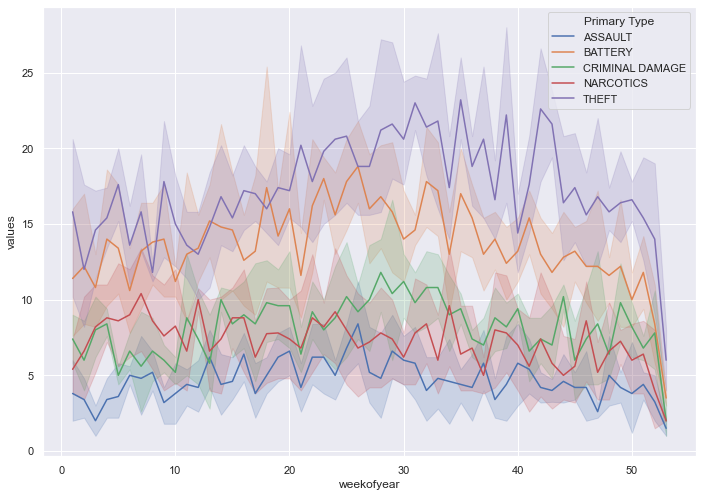

In [ ]:
plot_ts("weekofyear")

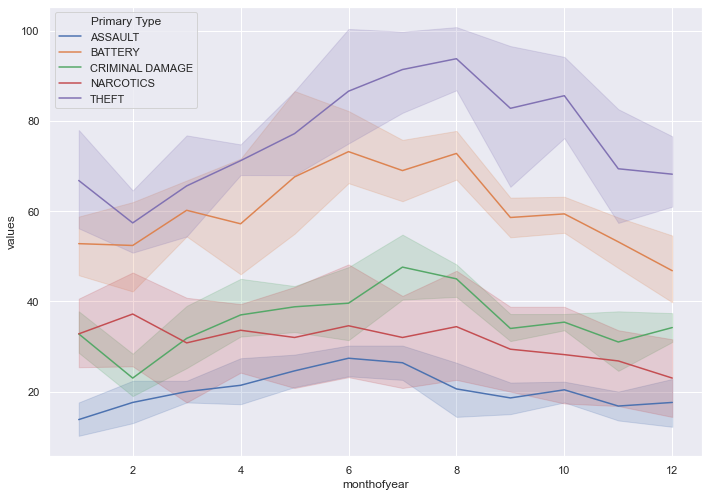

In [ ]:
plot_ts("monthofyear")

In [ ]:
# chicago = folium.Map(
#     location=[41.881832, -87.623177], 
#     zoom_start=11
# )

# for i, row in filtered_df.iterrows():
#     folium.CircleMarker(
#         location = (row["Latitude"], row["Longitude"]),
#         icon = folium.Icon(
#             icon_color = folium_colors[crimes_types.index(row["Primary Type"])]
#         ),
#         fill = True
#     ).add_to(chicago)

# chicago

In [ ]:
import plotly.express as px

px.set_mapbox_access_token(open(".mapbox_token").read())

fig = px.scatter_mapbox(
    filtered_df, 
    lat="Latitude", 
    lon="Longitude",     
    color="Primary Type", 
    # size="car_hours",
    color_continuous_scale = px.colors.carto, # px.colors.cyclical.IceFire, 
    size_max=15, 
    zoom=10
)
fig.show()

ModuleNotFoundError: No module named 'plotly'